In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import scipy.io as sio

In [26]:
# Step 1: Load Dataset
data = sio.loadmat("C:/Users/Thanh Dam/Downloads/umist_cropped.mat")
images = data['facedat']
dirnames = data['dirnames']

Initial Dataset Visualization


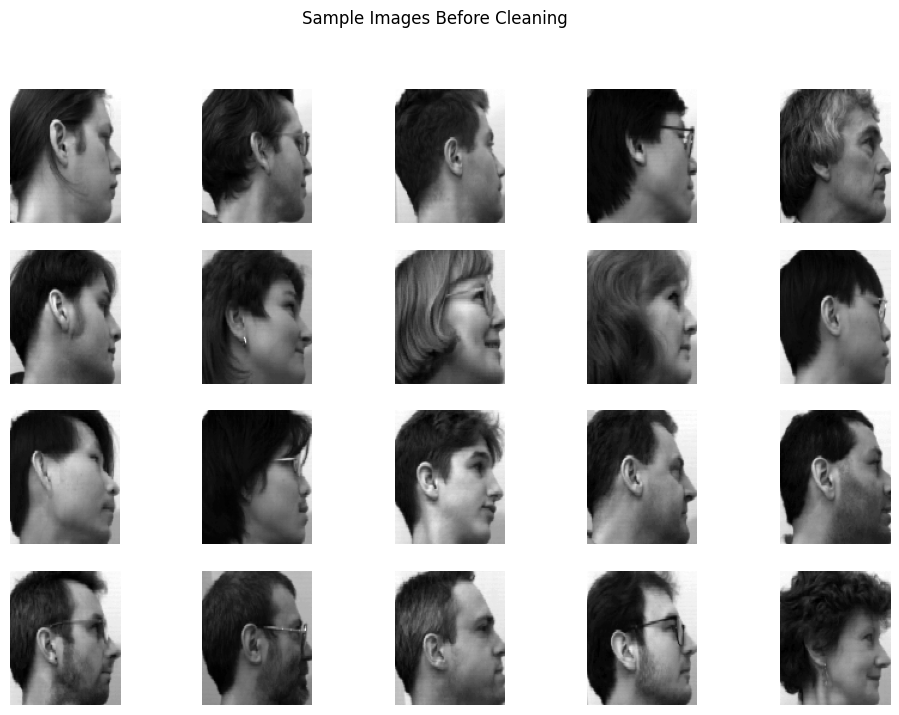

In [27]:
# Visualize a few sample images
def visualize_samples(images, title):
    plt.figure(figsize=(12, 8))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        sample_image = images[i][:, :, 0]  # First image per subject
        plt.imshow(sample_image, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

print("Initial Dataset Visualization")
visualize_samples(images[0], "Sample Images Before Cleaning")

In [28]:
# Step 2: Data Cleaning - Remove Duplicates
def remove_duplicates_mse(subjects, threshold=1e-6):
    
    cleaned_subjects = []
    for subject_images in subjects:
        unique_images = []
        for i in range(subject_images.shape[2]):
            current_image = subject_images[:, :, i]
            is_duplicate = False
            for unique_image in unique_images:
                mse = np.mean((current_image - unique_image) ** 2)
                if mse < threshold:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_images.append(current_image)
        cleaned_subjects.append(np.stack(unique_images, axis=2))
    return cleaned_subjects


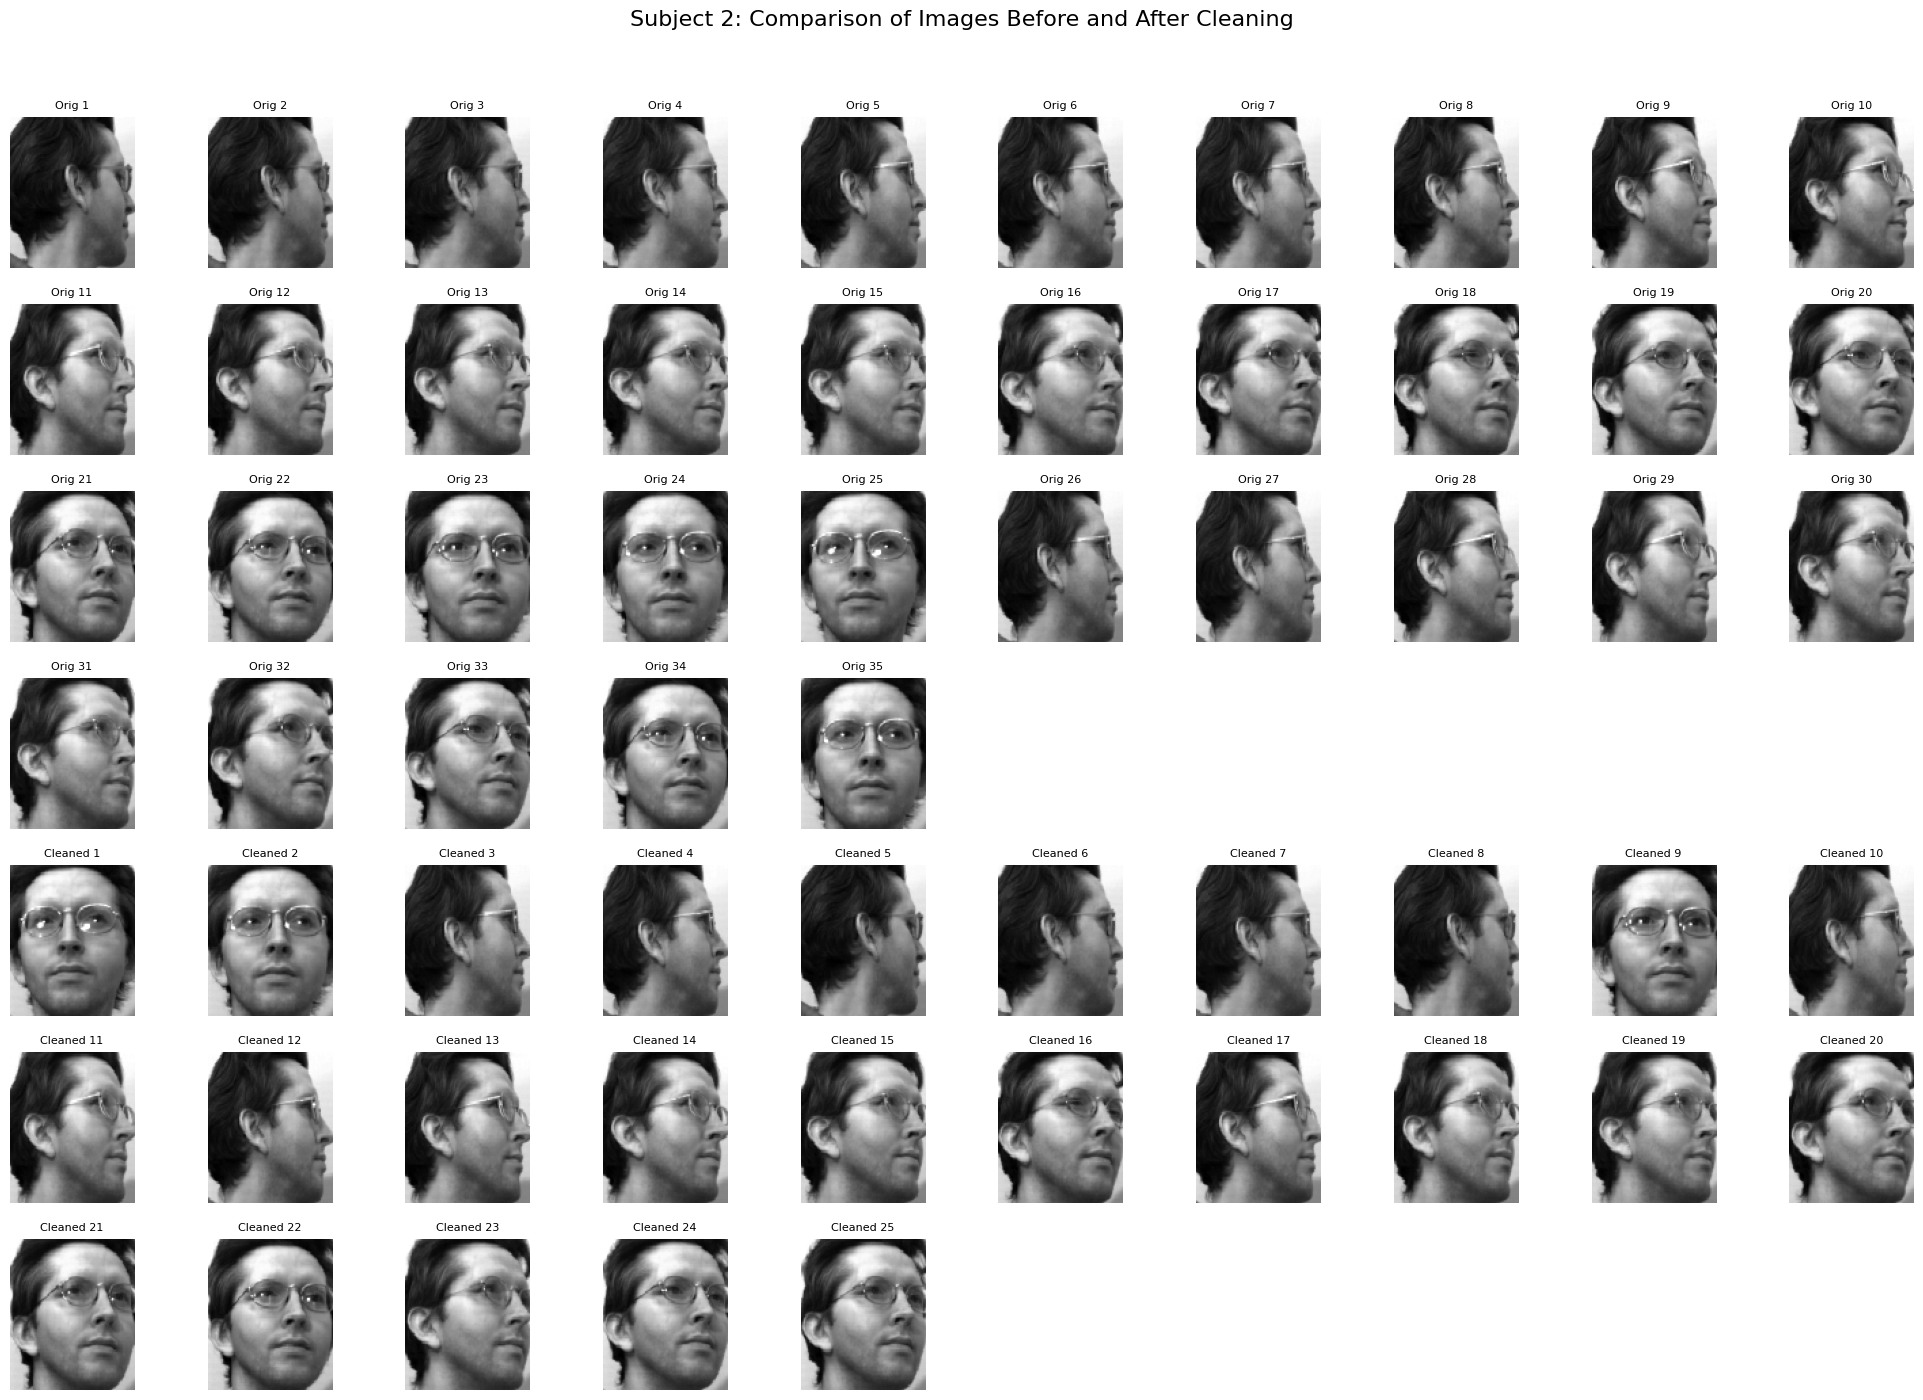

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_before_after_cleaning(original_images, cleaned_images, subject_idx):

    original_subject_images = original_images[subject_idx]  # Original images for the selected subject
    cleaned_subject_images = cleaned_images[subject_idx]    # Cleaned images for the selected subject

    # Determine the number of images before and after cleaning
    num_original_images = original_subject_images.shape[2]
    num_cleaned_images = cleaned_subject_images.shape[2]

    # Define grid size
    cols = 10  # Number of columns
    rows_original = -(-num_original_images // cols)  # Calculate rows for original images
    rows_cleaned = -(-num_cleaned_images // cols)    # Calculate rows for cleaned images

    # Set up the figure
    total_rows = rows_original + rows_cleaned  # Total rows in the figure
    fig_height = total_rows * 2  # Scale figure height dynamically
    plt.figure(figsize=(cols * 2, fig_height))

    # Display original images
    for i in range(num_original_images):
        plt.subplot(total_rows, cols, i + 1)
        plt.imshow(original_subject_images[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Orig {i + 1}", fontsize=8)

    # Display cleaned images
    for i in range(num_cleaned_images):
        plt.subplot(total_rows, cols, rows_original * cols + i + 1)
        plt.imshow(cleaned_subject_images[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Cleaned {i + 1}", fontsize=8)

    # Add a centered main title
    plt.suptitle(
        f"Subject {subject_idx + 1}: Comparison of Images Before and After Cleaning",
        fontsize=16,
        y=1 - (0.05 / fig_height)  # Adjust title position dynamically
    )
    plt.tight_layout(h_pad=1.5, w_pad=0.5)  # Add space between rows and columns
    plt.subplots_adjust(top=0.92)  # Ensure main title does not overlap
    plt.show()

visualize_before_after_cleaning(images[0], cleaned_subjects, subject_idx=1)

In [29]:
# Step 3: Prepare Data for Training
X, y = [], []
for subject_idx, subject_images in enumerate(cleaned_subjects):
    num_images = subject_images.shape[2]
    for img_idx in range(num_images):
        X.append(subject_images[:, :, img_idx].flatten())
        y.append(subject_idx)

X = np.array(X)
y = np.array(y)

In [30]:
# Step 4: Normalize Data
X_normalized = X / 255.0

In [31]:
# Step 5: Split Dataset (Stratified Sampling)
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


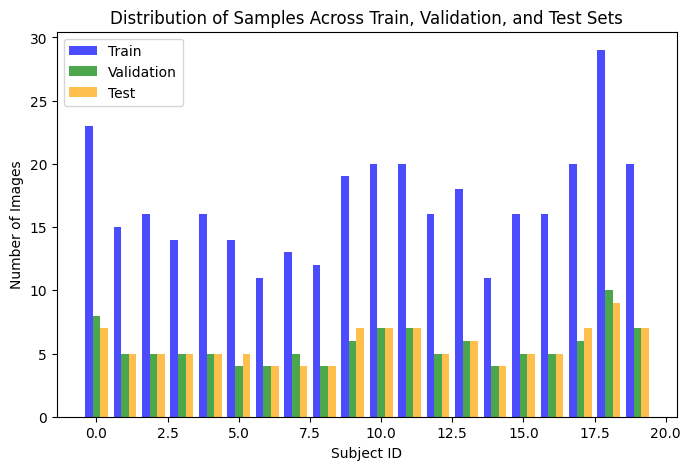

In [32]:
# Visualize sample distribution
plt.figure(figsize=(8, 5))
plt.hist([y_train, y_val, y_test], bins=np.arange(21) - 0.5, label=["Train", "Validation", "Test"], align="mid", color=["blue", "green", "orange"], alpha=0.7)
plt.xlabel("Subject ID")
plt.ylabel("Number of Images")
plt.title("Distribution of Samples Across Train, Validation, and Test Sets")
plt.legend()
plt.show()

In [33]:
# Step 6: Dimensionality Reduction with PCA
pca = PCA(0.95)  # Preserve 95% variance
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [34]:
print(f"Original Dimensionality: {X_train.shape[1]}, Reduced Dimensionality: {X_train_pca.shape[1]}")

Original Dimensionality: 10304, Reduced Dimensionality: 90


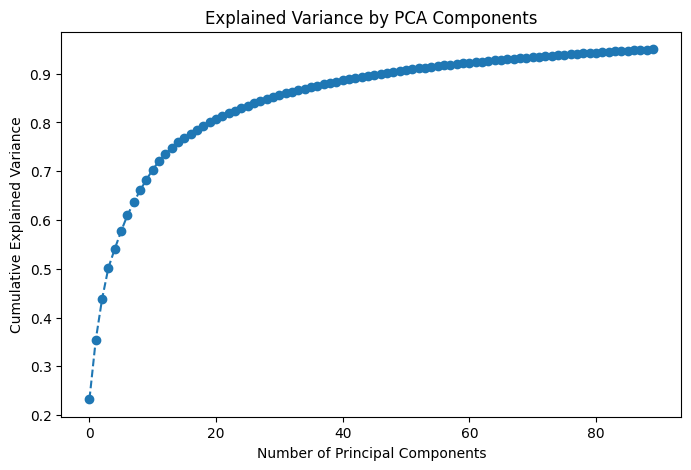

In [35]:
# Visualize explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.show()

In [36]:
# Step 7: Clustering with GMM
gmm = GaussianMixture(n_components=len(np.unique(y)), covariance_type='full', random_state=42)
gmm.fit(X_train_pca)

GaussianMixture(n_components=20, random_state=42)

In [37]:
# Predict clusters for evaluation
train_clusters = gmm.predict(X_train_pca)

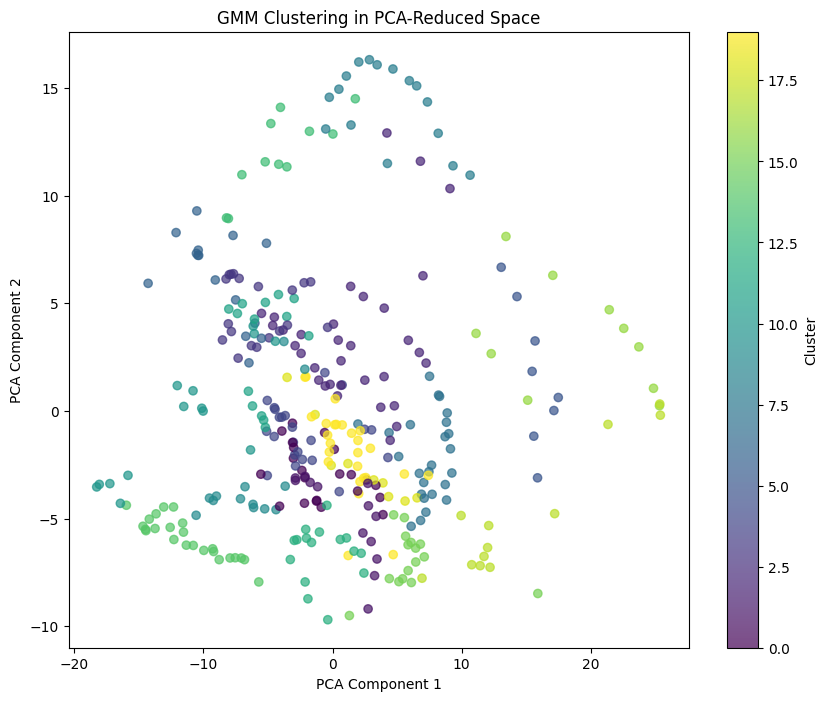

In [38]:
# Visualize clusters in PCA space
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("GMM Clustering in PCA-Reduced Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

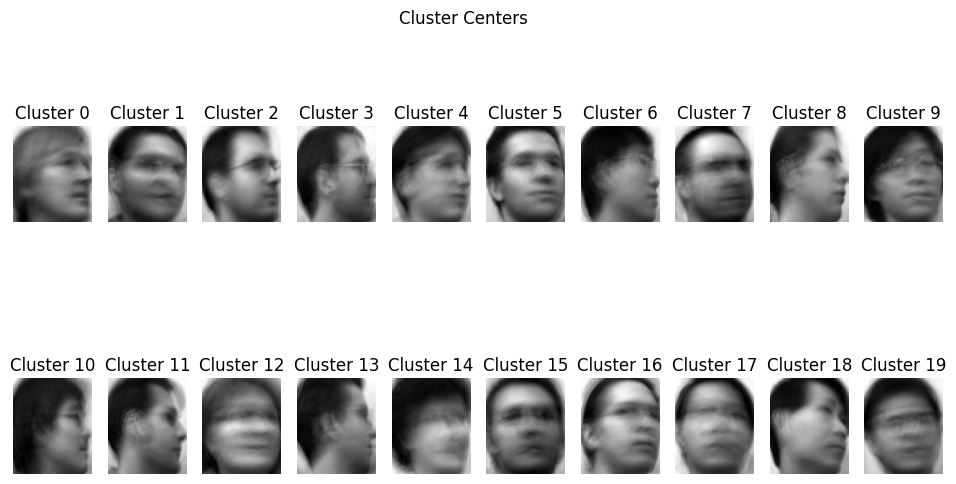

In [39]:
# Step 8: Visualize Cluster Centers
def visualize_cluster_centers(pca, gmm):
    cluster_centers = pca.inverse_transform(gmm.means_)  # Transform back to original space
    plt.figure(figsize=(12, 6))
    for i, center in enumerate(cluster_centers):
        plt.subplot(2, len(cluster_centers) // 2, i + 1)
        plt.imshow(center.reshape(112, 92), cmap='gray')
        plt.axis('off')
        plt.title(f"Cluster {i}")
    plt.suptitle("Cluster Centers")
    plt.show()

visualize_cluster_centers(pca, gmm)